# Training and Evaluation for All Features

In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from scipy import interp

data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

cv_token_pattern = u'[^;]+'

In [2]:
def train_plot_roc(X, y, n_splits=10):
    # Trying ROC
    skf = StratifiedKFold(n_splits=n_splits)
    classifier = LogisticRegression(C=1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10, 4), dpi=100)

    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 0.25])
    plt.ylim([0.50, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return (mean_fpr, mean_tpr, classifier)

In [3]:
# imports = pd.read_csv(build_path('learn_imports')).set_index('link')
a = pd.read_csv(build_path('learn_signatures')).set_index('link')
b = pd.read_csv(build_path('learn_imports')).set_index('link')
# signatures = pd.read_csv(build_path('learn_signatures')).set_index('link')

In [4]:
big_dataset = a.drop('malware', axis=1).join(
    b.drop('malware', axis=1), lsuffix='b_').fillna(0)

In [5]:
valid_samples = pd.read_csv(build_path('all_samples')).set_index('link').index
big_dataset = big_dataset.loc[big_dataset.index.isin(valid_samples)]

In [6]:
malware = a[a.malware == True].index
malware = malware.join(b[b.malware == True].index)

In [7]:
goodware = a[a.malware == False].index
goodware = goodware.join(b[b.malware == False].index)

In [8]:
malware_labeled = pd.read_csv(build_path('malware_labeled')).set_index('link')
malware_labeled = malware_labeled.astype(float)

In [9]:
big_dataset.loc[big_dataset.index.isin(malware), 'malware'] = True
big_dataset.loc[big_dataset.index.isin(goodware), 'malware'] = False

In [10]:
malware = big_dataset[(big_dataset.malware == 1) & (big_dataset.index.isin(malware_labeled.index))].index
goodware = big_dataset[(big_dataset.malware == 0) & ~(big_dataset.index.isin(malware_labeled.index))].index
big_dataset = big_dataset[(big_dataset.index.isin(malware)) | (big_dataset.index.isin(goodware))]

## Baseline Classifier
Single LR for malware vs goodware using static imports

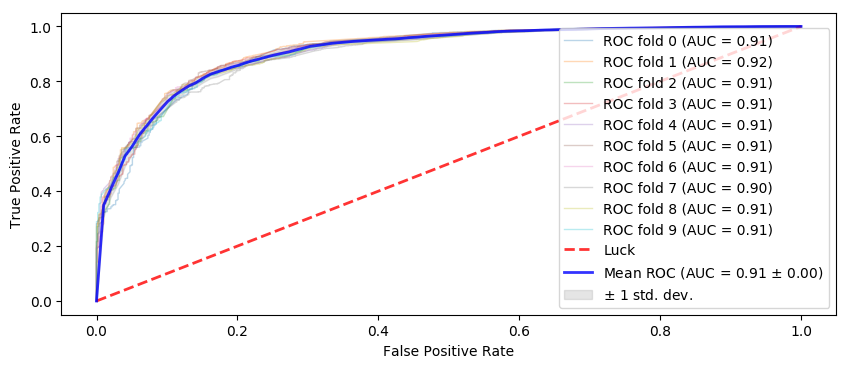

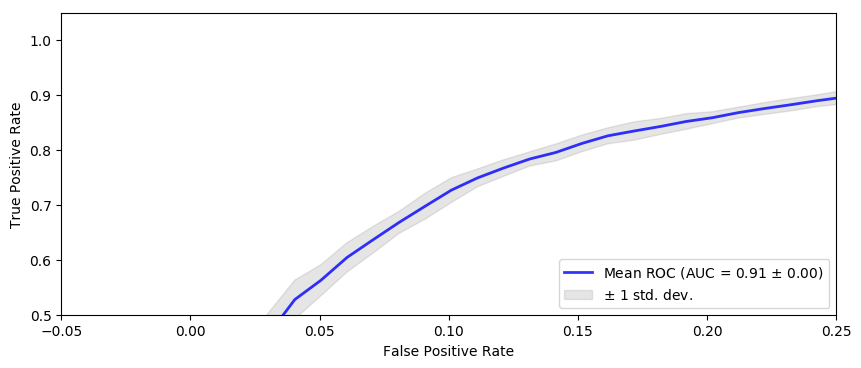

CPU times: user 10.9 s, sys: 6.04 s, total: 16.9 s
Wall time: 9.03 s


In [11]:
%%time
data = shuffle(big_dataset)
train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)